# Visualizing graph of payment attempts

The visualization has to bee clear, in order to get insights from it.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
plt.rcParams['figure.dpi'] = 144
plt.rcParams['savefig.dpi'] = 144

In [4]:
file_path = '../Datos/payment-attempts.csv'
pay_att = pd.read_csv(file_path)

In [5]:
import json
from pandas import json_normalize

## Organize data

In [6]:
d = {}

for i, p in pay_att.iterrows():
    i_d = p['id']
    val = p['value_msat']
    htlc_json = json.loads(p['htlcs'])
    htlc_atts = json_normalize(htlc_json)
#     amt = htlc_atts.loc[0, 'route.total_amt_msat']

    for ix, row in htlc_atts.iterrows():
        
        try:
            failed = row['failure.failure_source_index']
        except:
            failed = np.nan
        
        # the path succeeded?
        status = row['status']
        
        hops = json_normalize(row['route.hops'])
        for h_ix, h in hops.iterrows():
            chan_id = h['chan_id']
            p_key = h['pub_key']
            try:
                fee_msat = h['fee_msat']
            except:
                fee_msat = 0
            
            if failed ==h_ix:
                d[(i_d, ix, h_ix)] = [chan_id, p_key, fee_msat, True, status]
            else:
                d[(i_d, ix, h_ix)] = [chan_id, p_key, fee_msat, False, status]

In [7]:
# multiindex dataframe
payment_atts = pd.DataFrame(index=d.keys(), data=d.values())

In [8]:
payment_atts.columns = ['chan_id', 'pub_key', 'fee_msat', 'hop_fail', 'pay_status']
payment_atts.index.set_names(['payment_id', 'attempt', 'hop'], inplace=True)

In [9]:
payment_atts

chan_id  \
payment_id attempt hop                       
6577       0       0    774770868577435649   
                   1    818066337947451393   
                   2    806562147822862337   
                   3    791128303121137665   
           1       0    774770868577435649   
...                                    ...   
6630       26      1    750057145744424961   
                   2    721103706067959809   
           27      0    778288206261059585   
                   1    816698545456480257   
                   2    817010806803070983   

                                                                  pub_key  \
payment_id attempt hop                                                      
6577       0       0    022eb09a7993a0edde69537b420f4119c0de833e0ee476...   
                   1    038fe1bd966b5cb0545963490c631eaa1924e2c4c0ea4e...   
                   2    03d29a2fc370cf011a743d893de86ab9a920f2445539ea...   
                   3    035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8...   
           1       0    022eb09a7993a0edde69537b420f4119c0de833e0ee476...   
...                                                                   ...   
6630       26      1    02f6155b106a9f92a13738833ec7e25da58fab1fdef3ac...   
                   2    035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8...   
           27      0    036b53093df5a932deac828cca6d663472dbc88322b05e...   
                   1    02e4971e61a3f55718ae31e2eed19aaf2e32caf3eb5ef5...   
                   2    035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8...   

                        fee_msat  hop_fail  pay_status  
payment_id attempt hop                                  
6577       0       0     25000.0     False         2.0  
                   1         NaN     False         2.0  
                   2         NaN     False         2.0  
                   3         NaN      True         2.0  
           1       0     25000.0     False         2.0  
...                          ...       ...         ...  
6630       26      1     18628.0      True         2.0  
                   2         NaN     False         2.0  
           27      0     90998.0     False         2.0  
                   1     20927.0      True         2.0  
                   2         NaN     False         2.0  

[2908 rows x 5 columns]

Let's visualize the first payment attempt: id 6577

In [10]:
file_name = '../Datos/graph_metrics_2022-07-11.json'
graph_data = open(file_name, encoding='utf8')
graph_json = json.load(graph_data)
# converting data to pd dfs
nodes_graph = json_normalize(graph_json['nodes'])

In [11]:
def add_node_alias(df, nodes):

    
    df['node_alias'] = ''

    nodes_pubkeys = df['pub_key'].unique()
    
    for i in nodes_pubkeys:
        
        for ix, j in nodes[['pub_key', 'alias']].iterrows():
            
            if i == j['pub_key']:
                df.loc[df['pub_key'] == i, 'node_alias'] = j['alias']

                break    
    return df['node_alias']

In [12]:
pay_6577 = payment_atts.loc[(6577), :]

In [13]:
add_node_alias(pay_6577, nodes_graph)

attempt  hop
0        0                  Ngu Technologies
         1            zero fee routing | CLN
         2                        ₿itcoin-⚡️
         3               WalletOfSatoshi.com
1        0                  Ngu Technologies
         1            zero fee routing | CLN
         2      zero fee routing [TigerNode]
         3               WalletOfSatoshi.com
2        0                  Ngu Technologies
         1            zero fee routing | CLN
         2                       BtcPins.com
         3               WalletOfSatoshi.com
3        0                  Ngu Technologies
         1            zero fee routing | CLN
         2              03a893c133cbb14ec3d4
         3               WalletOfSatoshi.com
4        0                  Ngu Technologies
         1            zero fee routing | CLN
         2                              NERV
         3               WalletOfSatoshi.com
5        0                  Ngu Technologies
         1            zero fee routing | C

In [12]:
def add_source_and_dest(payment_df):
    """

    """
    # creating the graph df:
    graph_df = pd.DataFrame(index=range(payment_df.shape[0]), 
                        columns=['source', 'destination'])
    
    # for setting sources and dests
    l =[]
    subl = []
    c = 0

    ixs = payment_df.index
    lenixs = len(ixs)

    for t in ixs[1:]:

        if ixs[c][0] != t[0]:
            l.append(subl.copy())
            subl.clear()

        subl.append(t[1])

        c += 1
        if c == lenixs - 1:
            l.append(subl.copy())
        
    ixs = [[max(e)] * (max(e) + 1)  for e in l]
    use = ixs[0]
    [use.extend(e) for e in ixs[1:]]
    
    # setting sources
    c = 1
    c2 =0
    graph_df.loc[0, 'source'] = 'LN_Capital'
    for i, hop in payment_df.iterrows():
        if c2 == len(use):break
        if i[1] != (use[c2]):
            graph_df.loc[c, 'source'] = hop['node_alias']
            c += 1
        else:
            c2+=1
            if c2 == len(use):break
            graph_df.loc[c, 'source'] = 'LN_Capital'
            c += 1
            c2-=1
            
        c2+=1
    
    # setting destinations
    c = 1
    c2 = 0
    first_dest = payment_df.loc[(0,0), 'node_alias']
    graph_df.iloc[0, 1] = first_dest
    for i, hop in payment_df.iterrows():
        if c2 == len(use):break
        if i[1] != (use[c2]):
            # dest
            
            graph_df.loc[c, 'destination'] = payment_df.loc[(i[0], i[1]+1), 'node_alias']
            c += 1
            
        else: 
            c2+=1
            if c2 == len(use):break
            graph_df.iloc[c, 1] = first_dest
            c += 1
            c2-=1
            
        c2+=1
    
    return graph_df #, routes_normalized

In [15]:
pay_6599 = payment_atts.loc[(6599), :]
add_node_alias(pay_6599, nodes_graph)

attempt  hop
0        0                         Milky Way
         1            lightning-roulette.com
         2               WalletOfSatoshi.com
1        0                         Milky Way
         1                   SWISS.SOVEREIGN
         2                HoernchenLightning
         3                    indomitusBTC⚡️
         4               WalletOfSatoshi.com
2        0                         Milky Way
         1                   SWISS.SOVEREIGN
         2                HoernchenLightning
         3            zero fee routing | CLN
         4      BitcoinFTM.com aka The Lorax
         5               WalletOfSatoshi.com
3        0                         Milky Way
         1                   SWISS.SOVEREIGN
         2                    DiamondHands💎🙌
         3               WalletOfSatoshi.com
Name: node_alias, dtype: object

In [16]:
pay_6630 = payment_atts.loc[(6630), :]
add_node_alias(pay_6630, nodes_graph)

attempt  hop
0        0                         okcoin
         1              VIVA La Lightning
         2            WalletOfSatoshi.com
1        0                         okcoin
         1      1sats.com ⚡ dm to connect
                          ...            
26       1              VIVA La Lightning
         2            WalletOfSatoshi.com
27       0                         okcoin
         1      1sats.com ⚡ dm to connect
         2            WalletOfSatoshi.com
Name: node_alias, Length: 94, dtype: object

In [13]:
pay_6611 = payment_atts.loc[(6611), :]
add_node_alias(pay_6611, nodes_graph)

attempt  hop
0        0                          Peeky
         1                       DRBTCNGN
         2            WalletOfSatoshi.com
1        0                          Peeky
         1                        JKFLASH
         2            WalletOfSatoshi.com
2        0                          Peeky
         1           0204a91bb5802ad0a799
         2            WalletOfSatoshi.com
3        0                          Peeky
         1                     MidWestLNd
         2                   CoinPayments
         3            WalletOfSatoshi.com
4        0                          Peeky
         1           02f324df7694f57b7d80
         2                  Hodl Comrades
         3            WalletOfSatoshi.com
5        0                          Peeky
         1           02f324df7694f57b7d80
         2                 XLightningNode
         3            WalletOfSatoshi.com
6        0                          Peeky
         1           02f324df7694f57b7d80
         2           

In [14]:
edges_list = add_source_and_dest(pay_6611)

## Nodes position

**pseudoalgorithm**:

In a payment attempt:

1. Set our node position to the origin
2. For each route tried:
    - begin in our node
    - if next node has no pos:
        - set its pos to the curr node pos +10*x*
        - while pos already taken:
            - set pos -5*x* , + 5*y*
            - if that pos is already taken:
                - set pos -10*y*
    - else: pass

In [16]:
# get the indexes where the destination lies in
dest_ixs = edges_list[edges_list['destination'] == 'WalletOfSatoshi.com'].index.values

In [17]:
# Compute position of the nodes
# nodes_list = pd.DataFrame(edges_list['source'].unique())

nodes_list = []
for i, node in enumerate(edges_list['source']):
    nodes_list.append(node)
    if i in dest_ixs:
        nodes_list.append('WalletOfSatoshi.com')
    
    

In [18]:
nodes_list = pd.DataFrame(nodes_list)

In [19]:
nodes_list.tail(2)

,0
40,Dolphanarchist nodl [LND]
41,WalletOfSatoshi.com


In [20]:
nodes_list[['X', 'Y']] =np.nan

In [21]:
# setting our node position to the origin
nodes_list.loc[0, ['X', 'Y']] = 0 
nodes_list.head(2)

,0,X,Y
0,LN_Capital,0.0,0.0
1,Peeky,NaN,NaN


In [22]:
pos = (0,0) # beginnig of the route (our nodes pos)
dest_found = False
dest_pos = None

update = 20

for ix, node in nodes_list.iterrows():
    
    all_pos = list(zip(nodes_list['X'], nodes_list['Y'])) # list of tuples - each tup is a coord
    
    if (nodes_list.loc[ix, ['X', 'Y']].isna().sum() == 2) and (node[0] != 'LN_Capital'):
#         if dest_found and node[0] == 'WalletOfSatoshi.com':
#             nodes_list.loc[ix, 'X'] = dest_pos[0]
#             nodes_list.loc[ix, 'Y'] = dest_pos[1]
#             pos = (0,0)
#             continue
        pos = (pos[0] + 100, pos[1]) # increasing x coord 
        
        while pos in all_pos: # if pos already taken, change coords until new pos 
            pos = (pos[0] - 50 - update, pos[1] + 50)
            if pos in all_pos:
                pos = (pos[0], pos[1] -100 - update)
                update += 20
        
        nodes_list.loc[nodes_list[0] == node[0], 'X'] = pos[0]
        nodes_list.loc[nodes_list[0] == node[0], 'Y'] = pos[1]
        
#         if node[0] == 'WalletOfSatoshi.com' and not dest_found:
#             print('coño')
#             dest_pos = copy.copy(pos)
#             dest_found=True
            
    else:
        # node is ours. Set pos to origin
        if node[0] == 'LN_Capital':
            nodes_list.loc[ix, ['X', 'Y']] = 0
            pos = (0,0)
        else:
            pos = (nodes_list.loc[ix, 'X'], nodes_list.loc[ix, 'Y'])

In [23]:
nodes_list.rename({0:'node_alias'}, axis=1, inplace=True)

In [24]:
# add color attribute
# our node yellow, the destination purple, the rest gray 
nodes_list['color'] = 'gray'
nodes_list.loc[nodes_list['node_alias'] == 'LN_Capital', 'color'] = 'blue'
nodes_list.loc[nodes_list['node_alias'] == 'WalletOfSatoshi.com', 'color'] = 'green'

In [25]:
nodes_list['color'].value_counts()

gray     24
blue      9
green     9
Name: color, dtype: int64

In [26]:
# directed graph
g = nx.DiGraph()

In [27]:
# adding edges
for i, row in edges_list.iterrows():
    g.add_edge(row[0], row[1])

In [28]:
# adding position as a node attribute
for i, row in nodes_list.iterrows():
    g.nodes[row['node_alias']].update(row[1:].to_dict())

In [29]:
print(g.nodes.data())

[('LN_Capital', {'X': 0.0, 'Y': 0.0, 'color': 'blue'}), ('Peeky', {'X': 100.0, 'Y': 0.0, 'color': 'gray'}), ('DRBTCNGN', {'X': 200.0, 'Y': 0.0, 'color': 'gray'}), ('WalletOfSatoshi.com', {'X': 300.0, 'Y': 0.0, 'color': 'green'}), ('JKFLASH', {'X': 130.0, 'Y': 50.0, 'color': 'gray'}), ('0204a91bb5802ad0a799', {'X': 130.0, 'Y': -70.0, 'color': 'gray'}), ('MidWestLNd', {'X': 110.0, 'Y': 50.0, 'color': 'gray'}), ('CoinPayments', {'X': 210.0, 'Y': 50.0, 'color': 'gray'}), ('02f324df7694f57b7d80', {'X': 110.0, 'Y': -90.0, 'color': 'gray'}), ('Hodl Comrades', {'X': 210.0, 'Y': -90.0, 'color': 'gray'}), ('XLightningNode', {'X': 100.0, 'Y': -40.0, 'color': 'gray'}), ('Polygon', {'X': 100.0, 'Y': -200.0, 'color': 'gray'}), ('Rocky&FatCat.WUMBO.LND', {'X': 70.0, 'Y': 50.0, 'color': 'gray'}), ('2Wallet', {'X': 170.0, 'Y': 50.0, 'color': 'gray'}), ('Cowa Lightning', {'X': 70.0, 'Y': -130.0, 'color': 'gray'}), ('Dolphanarchist nodl [LND]', {'X': 170.0, 'Y': -130.0, 'color': 'gray'})]


In [30]:
# Define node positions data structure (dict) for plotting
node_positions = {node[0]: (node[1]['X'], node[1]['Y']) for node in g.nodes(data=True)}

In [31]:
# Preview of node_positions
dict(list(node_positions.items())[0:5])

{'LN_Capital': (0.0, 0.0),
 'Peeky': (100.0, 0.0),
 'DRBTCNGN': (200.0, 0.0),
 'WalletOfSatoshi.com': (300.0, 0.0),
 'JKFLASH': (130.0, 50.0)}

In [32]:
# Define data structure (list) of edge colors for plotting
nodes_colors = [c['color'] for *_, c in g.nodes(data=True)]

# Preview first 10
nodes_colors[0:10]

['blue',
 'gray',
 'gray',
 'green',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray',
 'gray']

In [35]:
nodes_labels = {node[0]: node[0] for node in g.nodes(data=True)}

In [37]:
nodes_labels['LN_Capital'] = 'Our Node'

In [38]:
def show_graph_of_routes(g, node_positions, nodes_colors, widths=1, 
                         edges_colors='black', nodes_size=700, draw_fee_labels=False,
                         fee_labels=None):
    plt.figure(figsize=(12, 9))
    # drawing nodes
    nx.draw_networkx_nodes(g, pos=node_positions, node_size=nodes_size, 
                           node_color=nodes_colors, alpha=0.5,
                           )
    # drawing edges
    nx.draw_networkx_edges(
        g, pos=node_positions, 
        connectionstyle="arc3,rad=-0.1",  # curve the edges
        width=widths,
        edge_color=edges_colors,
    )
    
    # labels
    nx.draw_networkx_labels(g, pos=node_positions, labels=nodes_labels,
                            font_size=5, font_family="sans-serif",
                            font_color='purple', verticalalignment='top')
    if draw_fee_labels:
        nx.draw_networkx_edge_labels(g, pos=node_positions, edge_labels=fee_labels,
                                 font_size=4, label_pos=0.35)
    
    _ = plt.title('Graph Representation of the routes attempted trying to pay an invoice', size=15)

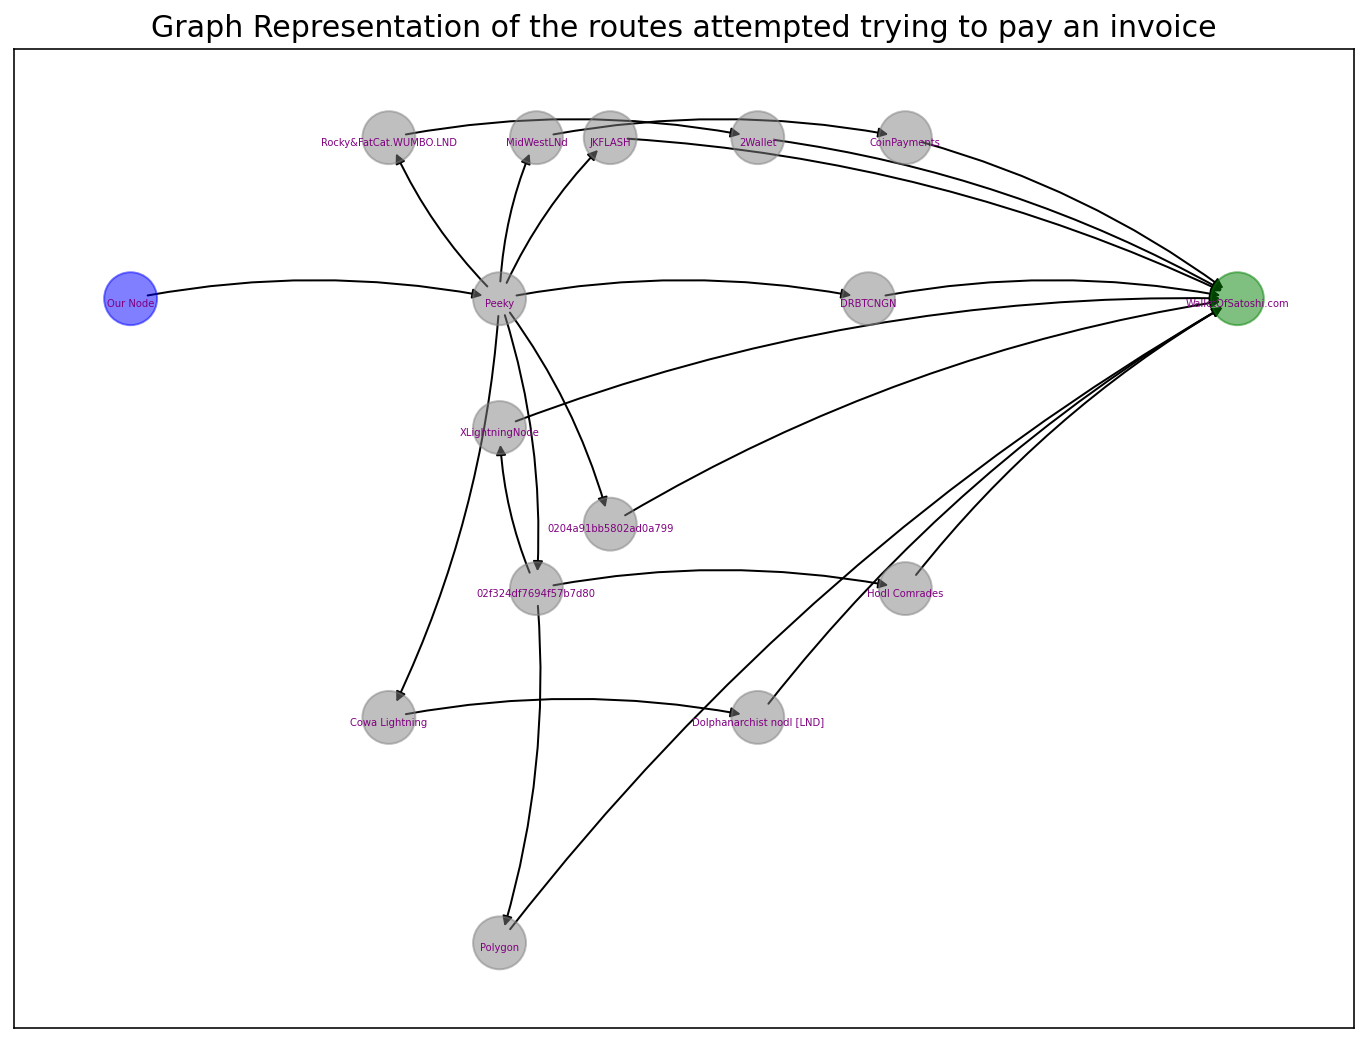

In [39]:
show_graph_of_routes(g, node_positions, nodes_colors)

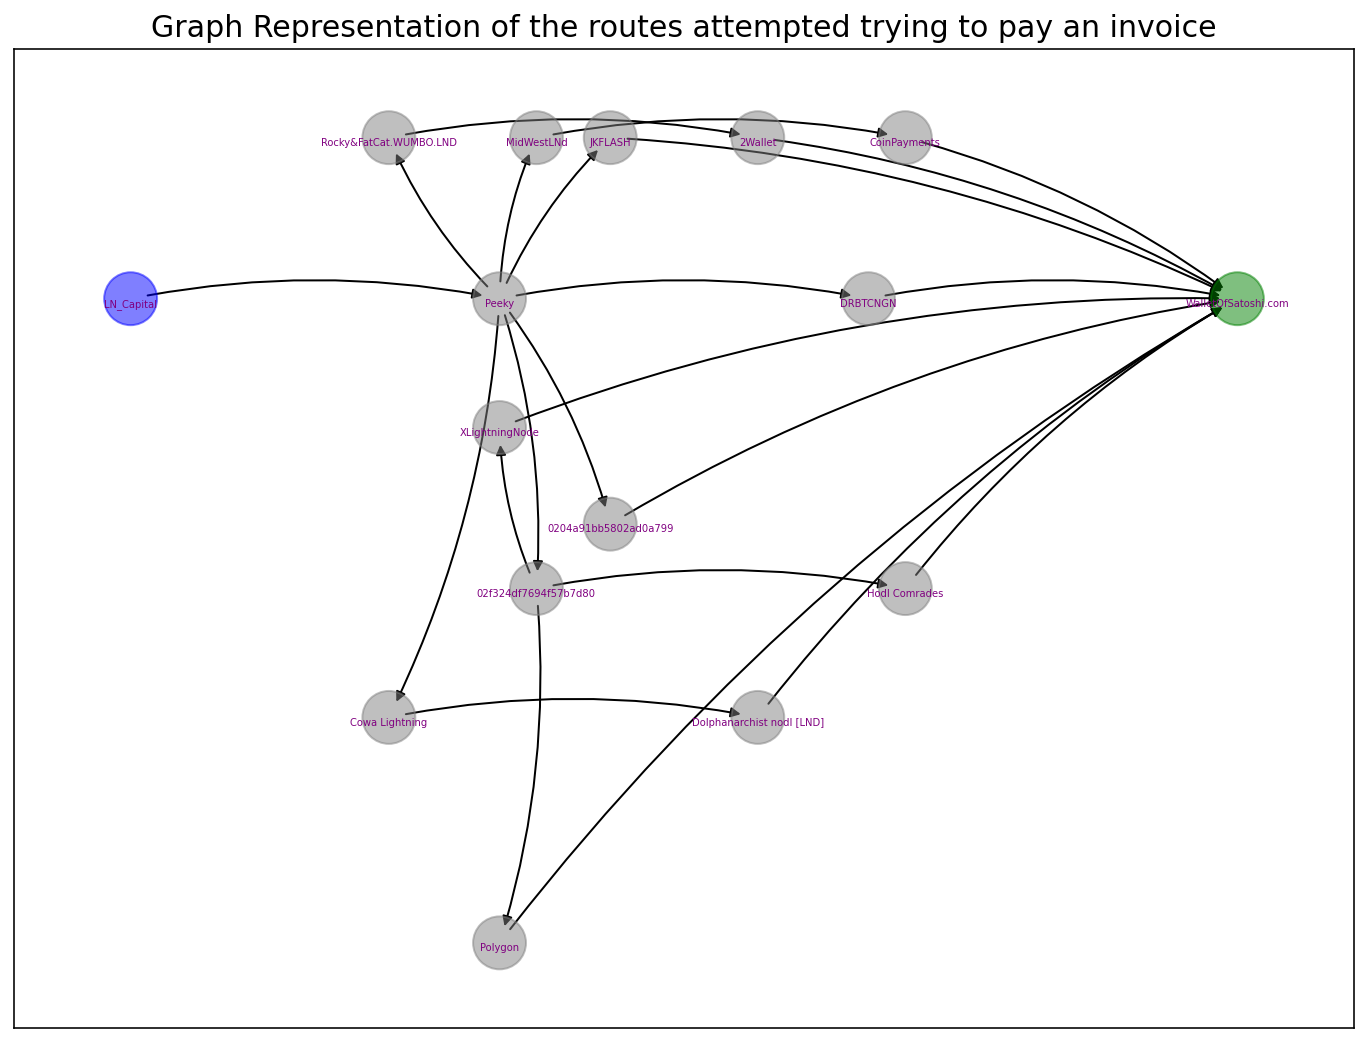

In [38]:
show_graph_of_routes(g, node_positions, nodes_colors)

## Edge width depending on the amount of attempts of a channel

In [40]:
def count_attempts(edges_df):
    
    df = edges_df.copy()
    df['peers'] = list(zip(df.source, df.destination))
    
    return df.groupby('peers').size()

In [41]:
channels_att_count = count_attempts(edges_list)
channels_att_count = channels_att_count.to_dict()

In [42]:
channels_att_count

{('0204a91bb5802ad0a799', 'WalletOfSatoshi.com'): 1,
 ('02f324df7694f57b7d80', 'Hodl Comrades'): 1,
 ('02f324df7694f57b7d80', 'Polygon'): 1,
 ('02f324df7694f57b7d80', 'XLightningNode'): 1,
 ('2Wallet', 'WalletOfSatoshi.com'): 1,
 ('CoinPayments', 'WalletOfSatoshi.com'): 1,
 ('Cowa Lightning', 'Dolphanarchist nodl [LND]'): 1,
 ('DRBTCNGN', 'WalletOfSatoshi.com'): 1,
 ('Dolphanarchist nodl [LND]', 'WalletOfSatoshi.com'): 1,
 ('Hodl Comrades', 'WalletOfSatoshi.com'): 1,
 ('JKFLASH', 'WalletOfSatoshi.com'): 1,
 ('LN_Capital', 'Peeky'): 9,
 ('MidWestLNd', 'CoinPayments'): 1,
 ('Peeky', '0204a91bb5802ad0a799'): 1,
 ('Peeky', '02f324df7694f57b7d80'): 3,
 ('Peeky', 'Cowa Lightning'): 1,
 ('Peeky', 'DRBTCNGN'): 1,
 ('Peeky', 'JKFLASH'): 1,
 ('Peeky', 'MidWestLNd'): 1,
 ('Peeky', 'Rocky&FatCat.WUMBO.LND'): 1,
 ('Polygon', 'WalletOfSatoshi.com'): 1,
 ('Rocky&FatCat.WUMBO.LND', '2Wallet'): 1,
 ('XLightningNode', 'WalletOfSatoshi.com'): 1}

In [43]:
our_peer = edges_list.loc[0, 'destination']

In [44]:
channels_att_count[('LN_Capital', our_peer)] = 1

In [45]:
# scale the attempts for the channel widths
from sklearn.preprocessing import MinMaxScaler

In [46]:


scaler = MinMaxScaler((0.1, 1))
dict_vals = np.array(list(channels_att_count.values())).reshape(-1, 1)
norm_vals = scaler.fit_transform(dict_vals)
norm_chann_count = {}
for i, k in enumerate(channels_att_count):
    norm_chann_count[k] = norm_vals[i]

In [47]:
channels_att_count

{('0204a91bb5802ad0a799', 'WalletOfSatoshi.com'): 1,
 ('02f324df7694f57b7d80', 'Hodl Comrades'): 1,
 ('02f324df7694f57b7d80', 'Polygon'): 1,
 ('02f324df7694f57b7d80', 'XLightningNode'): 1,
 ('2Wallet', 'WalletOfSatoshi.com'): 1,
 ('CoinPayments', 'WalletOfSatoshi.com'): 1,
 ('Cowa Lightning', 'Dolphanarchist nodl [LND]'): 1,
 ('DRBTCNGN', 'WalletOfSatoshi.com'): 1,
 ('Dolphanarchist nodl [LND]', 'WalletOfSatoshi.com'): 1,
 ('Hodl Comrades', 'WalletOfSatoshi.com'): 1,
 ('JKFLASH', 'WalletOfSatoshi.com'): 1,
 ('LN_Capital', 'Peeky'): 1,
 ('MidWestLNd', 'CoinPayments'): 1,
 ('Peeky', '0204a91bb5802ad0a799'): 1,
 ('Peeky', '02f324df7694f57b7d80'): 3,
 ('Peeky', 'Cowa Lightning'): 1,
 ('Peeky', 'DRBTCNGN'): 1,
 ('Peeky', 'JKFLASH'): 1,
 ('Peeky', 'MidWestLNd'): 1,
 ('Peeky', 'Rocky&FatCat.WUMBO.LND'): 1,
 ('Polygon', 'WalletOfSatoshi.com'): 1,
 ('Rocky&FatCat.WUMBO.LND', '2Wallet'): 1,
 ('XLightningNode', 'WalletOfSatoshi.com'): 1}

In [48]:
for k, v in norm_chann_count.items():
    g[k[0]][k[1]]['attempts'] = v * 5

In [49]:
widths = np.array([w for *_, w in g.edges.data('attempts')])

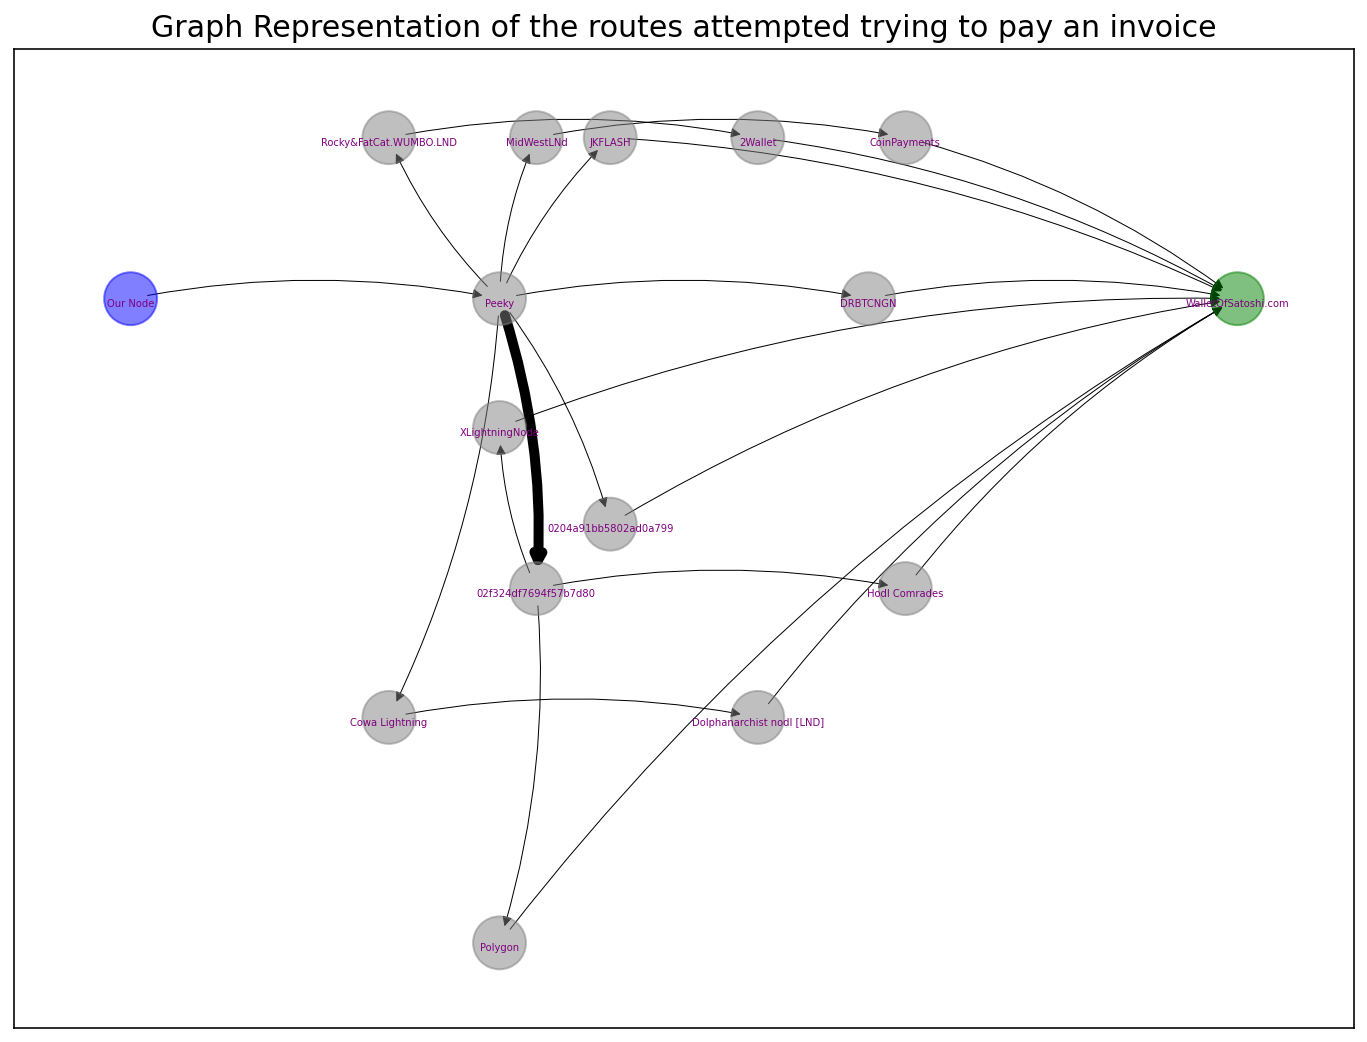

In [50]:
show_graph_of_routes(g, node_positions, nodes_colors, widths)

## Edge color depending on wheather a channel has failed.

In [51]:
def determine_edge_color(edges_df, pay_df):
    
    edges = edges_df.copy()
    pay_att = pay_df.droplevel('attempt')
    
    pay_att.reset_index(drop=True, inplace=True)
    
    edges['has_failed'] = pay_att['hop_fail']
    edges['peers'] = list(zip(edges.source, edges.destination))
    failure_count = edges.groupby('peers')['has_failed'].sum()
    
    return failure_count.to_dict()

In [52]:
channels_failure_count = determine_edge_color(edges_list, pay_6611)

In [53]:
# channel colors
for k, v in channels_failure_count.items():
    g[k[0]][k[1]]['color'] = v 

In [54]:
edges_colors = np.array([col for *_, col in g.edges.data('color')])

In [55]:
# scale the colors

scaler = MinMaxScaler((0, 1))
dict_vals = np.array(edges_colors).reshape(-1, 1)
norm_color_vals = scaler.fit_transform(dict_vals)

In [56]:
colors = [(nor_c[0], 0, 0) for nor_c in norm_color_vals]

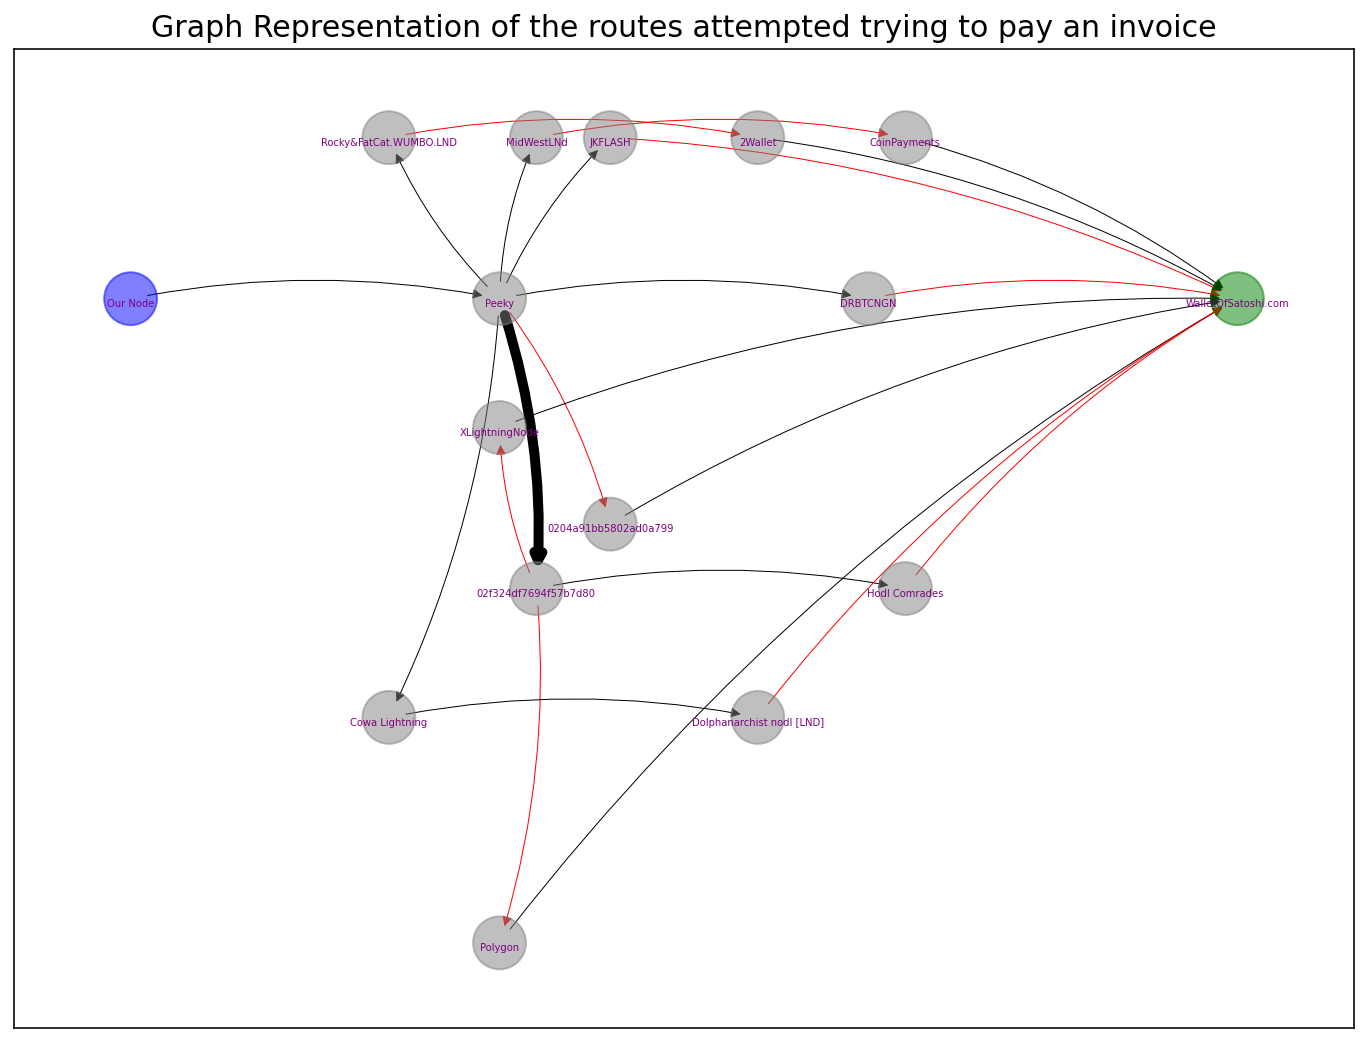

In [57]:
show_graph_of_routes(g, node_positions, nodes_colors, widths, colors)

## Nodes size depending on the attempts gone through it

In [58]:
our_peer

'Peeky'

In [59]:
destination_node = nodes_list.iloc[-1, 0]

In [60]:
def determine_nodes_size(nodes_df, our_peer, dest):
    
    nodes_occurrences = nodes_df.groupby('node_alias').size()
    mean_node_size = nodes_occurrences.mean()
    nodes_occurrences.loc[['LN_Capital', our_peer, dest]] = mean_node_size
    nodes_size = nodes_occurrences.to_dict()
    
    return nodes_size    

In [61]:
nodes_size = determine_nodes_size(nodes_list, our_peer, destination_node)

In [62]:
# channel colors
for k, v in nodes_size.items():
    g.nodes[k]['size'] = v 

In [63]:
nodes_size = np.array([size for *_, size in g.nodes.data('size')])

In [64]:
# normalizing node sizes
scaler = MinMaxScaler((0.1, 1))
dict_vals = np.array(nodes_size).reshape(-1, 1)
norm_size_vals = scaler.fit_transform(dict_vals)

In [65]:
node_size = [(nor_s[0]) * 1000 for nor_s in norm_size_vals] 
# multiplying norm size by a x1000 factor

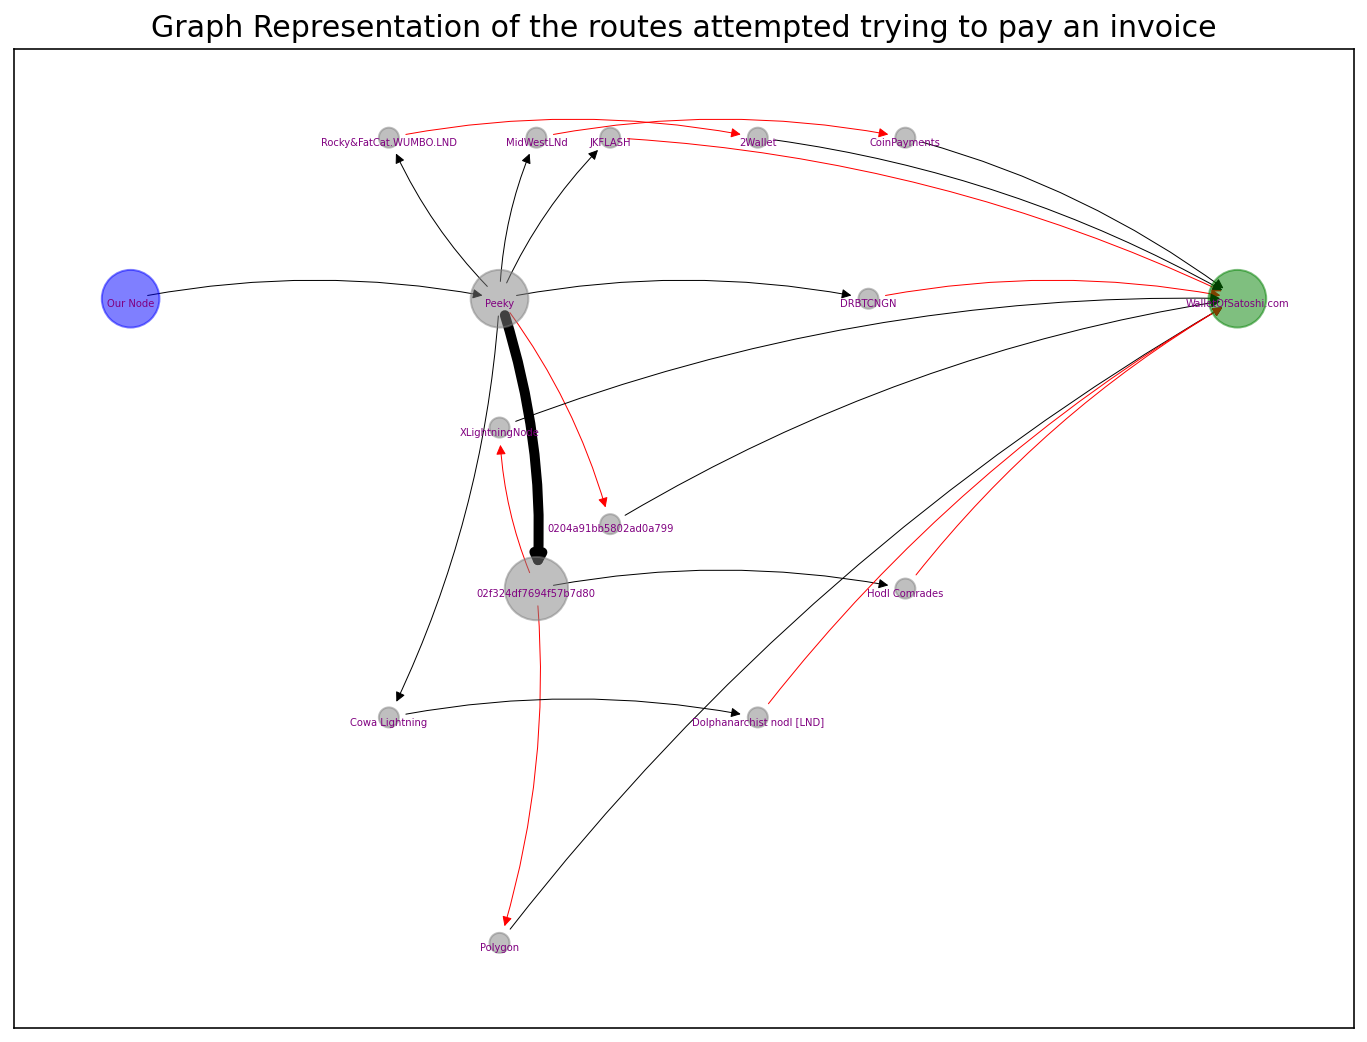

In [66]:
show_graph_of_routes(g, node_positions, nodes_colors, widths, colors, nodes_size=node_size)

## Drawing channel fees

In [67]:
def setting_fees(edges_df, pay_df):
    
    edges = edges_df.copy()
    # payment df has the fee_msat per hop
    payment = pay_df.droplevel('attempt')
    payment.reset_index(drop=True, inplace=True)
    
    edges['fee_msat'] = payment['fee_msat']
    
    edges['peers'] = list(zip(edges.source, edges.destination))
    
    
    attempted_fees = edges.groupby('peers').apply(lambda x: [fee for fee in x['fee_msat']])
    return attempted_fees

In [68]:
fees_per_channel = setting_fees(edges_list, pay_6611)

In [69]:
fees_dict = fees_per_channel.to_dict()
for k, v in fees_dict.items():
#     aggs = pd.Series(fees_dict[k]).aggregate(['min', 'median', 'mean', 'max']).values
    mean_fee = np.nanmean(np.asarray(v))
    g[k[0]][k[1]]['fees'] =  mean_fee if mean_fee >0 else 0  #np.nan_to_num(aggs)

In [70]:
fees_dict

{('0204a91bb5802ad0a799', 'WalletOfSatoshi.com'): [nan],
 ('02f324df7694f57b7d80', 'Hodl Comrades'): [50500.0],
 ('02f324df7694f57b7d80', 'Polygon'): [2500.0],
 ('02f324df7694f57b7d80', 'XLightningNode'): [nan],
 ('2Wallet', 'WalletOfSatoshi.com'): [nan],
 ('CoinPayments', 'WalletOfSatoshi.com'): [nan],
 ('Cowa Lightning', 'Dolphanarchist nodl [LND]'): [1500.0],
 ('DRBTCNGN', 'WalletOfSatoshi.com'): [nan],
 ('Dolphanarchist nodl [LND]', 'WalletOfSatoshi.com'): [nan],
 ('Hodl Comrades', 'WalletOfSatoshi.com'): [nan],
 ('JKFLASH', 'WalletOfSatoshi.com'): [nan],
 ('LN_Capital', 'Peeky'): [62490.0,
  97490.0,
  62490.0,
  17490.0,
  32493.0,
  32490.0,
  32490.0,
  nan,
  42493.0],
 ('MidWestLNd', 'CoinPayments'): [1500.0],
 ('Peeky', '0204a91bb5802ad0a799'): [6000.0],
 ('Peeky', '02f324df7694f57b7d80'): [7621.0, 8034.0, 8979.0],
 ('Peeky', 'Cowa Lightning'): [35000.0],
 ('Peeky', 'DRBTCNGN'): [1500.0],
 ('Peeky', 'JKFLASH'): [1500.0],
 ('Peeky', 'MidWestLNd'): [1500.0],
 ('Peeky', 'Rocky&

In [71]:
edge_fee_labels = nx.get_edge_attributes(g, 'fees')

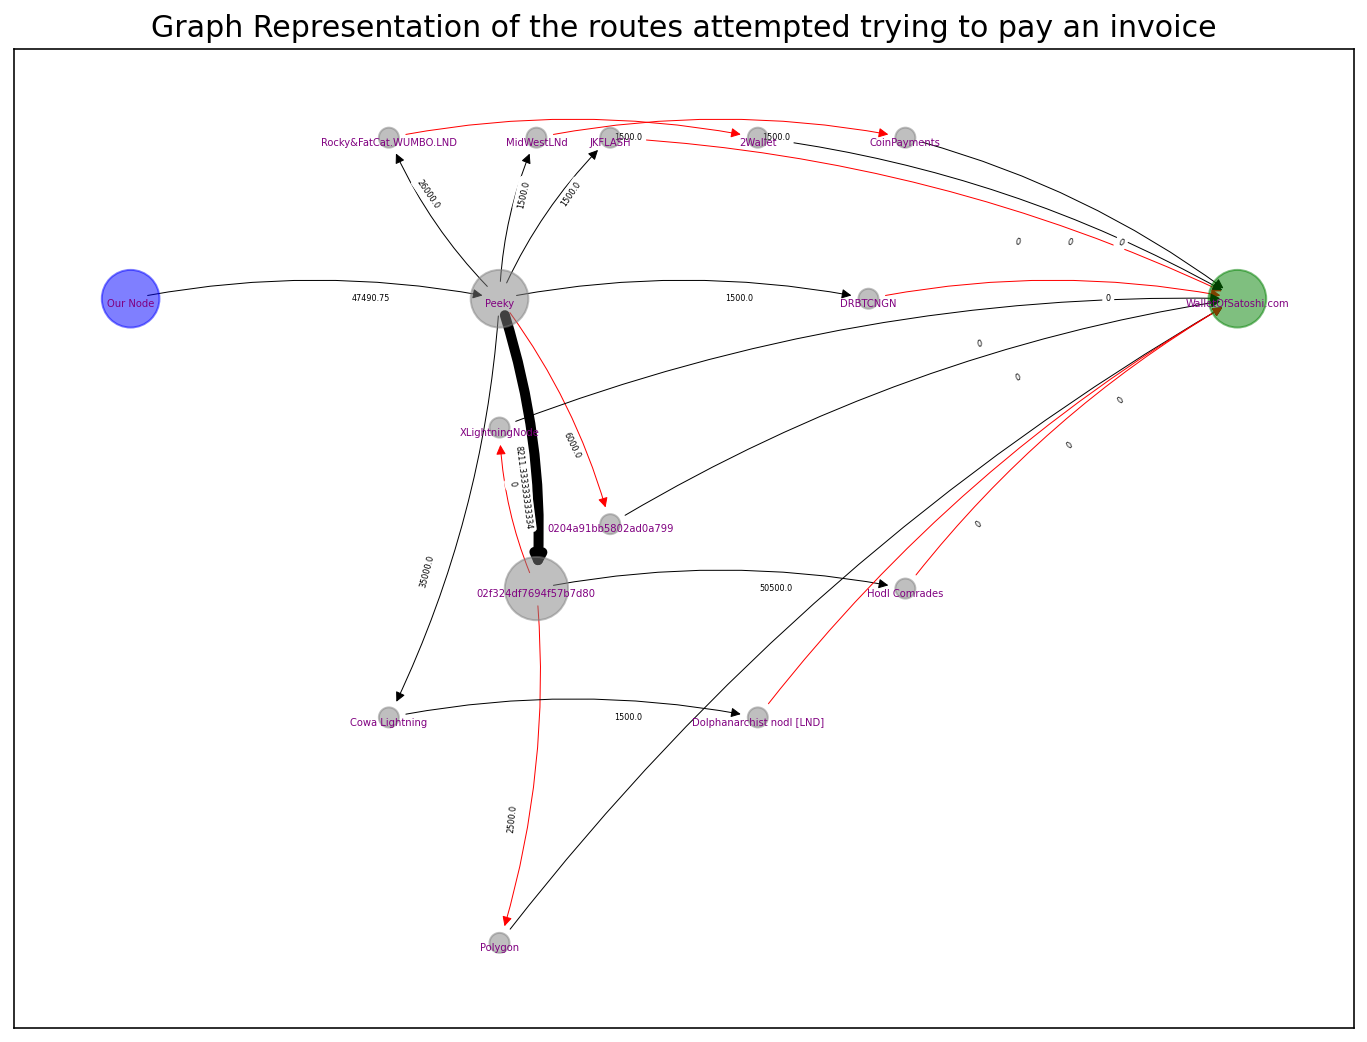

In [72]:
show_graph_of_routes(g, node_positions, nodes_colors, widths,
                     colors, nodes_size=node_size, draw_fee_labels=True,
                     fee_labels=edge_fee_labels)

## Colour channels that have never been attempted due to a failure before in the route.

If a channel has never been attempted, then the channel before in its route has to have the at least the same number of failures as number of attempts.

In [73]:
def colour_no_attempted_chans(graph, edges_df, destination_ixs,
                              channels_att_count, channels_failure_count):

    dest_ixs = [ix + 1 for ix in destination_ixs] # indices where our node is
    edges = edges_df.copy()
    edges[['att_count', 'failure_count', 'color']] = np.nan
    # iterate over each row
    for i, row in edges.iterrows():
        edges.loc[i, 'att_count'] = channels_att_count[(row.source, row.destination)]
        edges.loc[i, 'failure_count'] = channels_failure_count[(row.source, row.destination)]
        
    for i, row in edges.iterrows():
        if i == 0:
            continue
        if i in dest_ixs:
            continue
        
        if row['att_count'] <= edges.loc[i-1, 'failure_count']:
            edges.loc[i, 'color'] = 'tab:blue'
            
        else:
            edges.loc[i, 'color'] = graph[row.source][row.destination]['color']
    
    return edges

In [74]:
no_att_chan_colors = colour_no_attempted_chans(g, edges_list, dest_ixs,
                          channels_att_count, channels_failure_count)

In [75]:
colors_dict = {}
for e, c in zip(g.edges, colors):
    colors_dict[e] = {'color': c}
    

In [76]:
# setting colors again
nx.set_edge_attributes(g, colors_dict)

In [77]:
for i, row in no_att_chan_colors.iterrows():
    if type(row.color) is str:
        g[row.source][row.destination]['color'] = row.color

In [78]:
edges_colors = np.array([c for *_, c in g.edges.data('color')])

In [79]:
edges_colors

array([(0.0, 0, 0), (0.0, 0, 0), (0.0, 0, 0), (1.0, 0, 0), (0.0, 0, 0),
       (0.0, 0, 0), (0.0, 0, 0), (0.0, 0, 0), (1.0, 0, 0), (1.0, 0, 0),
       'tab:blue', (1.0, 0, 0), 'tab:blue', (0.0, 0, 0), (1.0, 0, 0),
       (1.0, 0, 0), (1.0, 0, 0), 'tab:blue', 'tab:blue', (1.0, 0, 0),
       'tab:blue', (0.0, 0, 0), (1.0, 0, 0)], dtype=object)

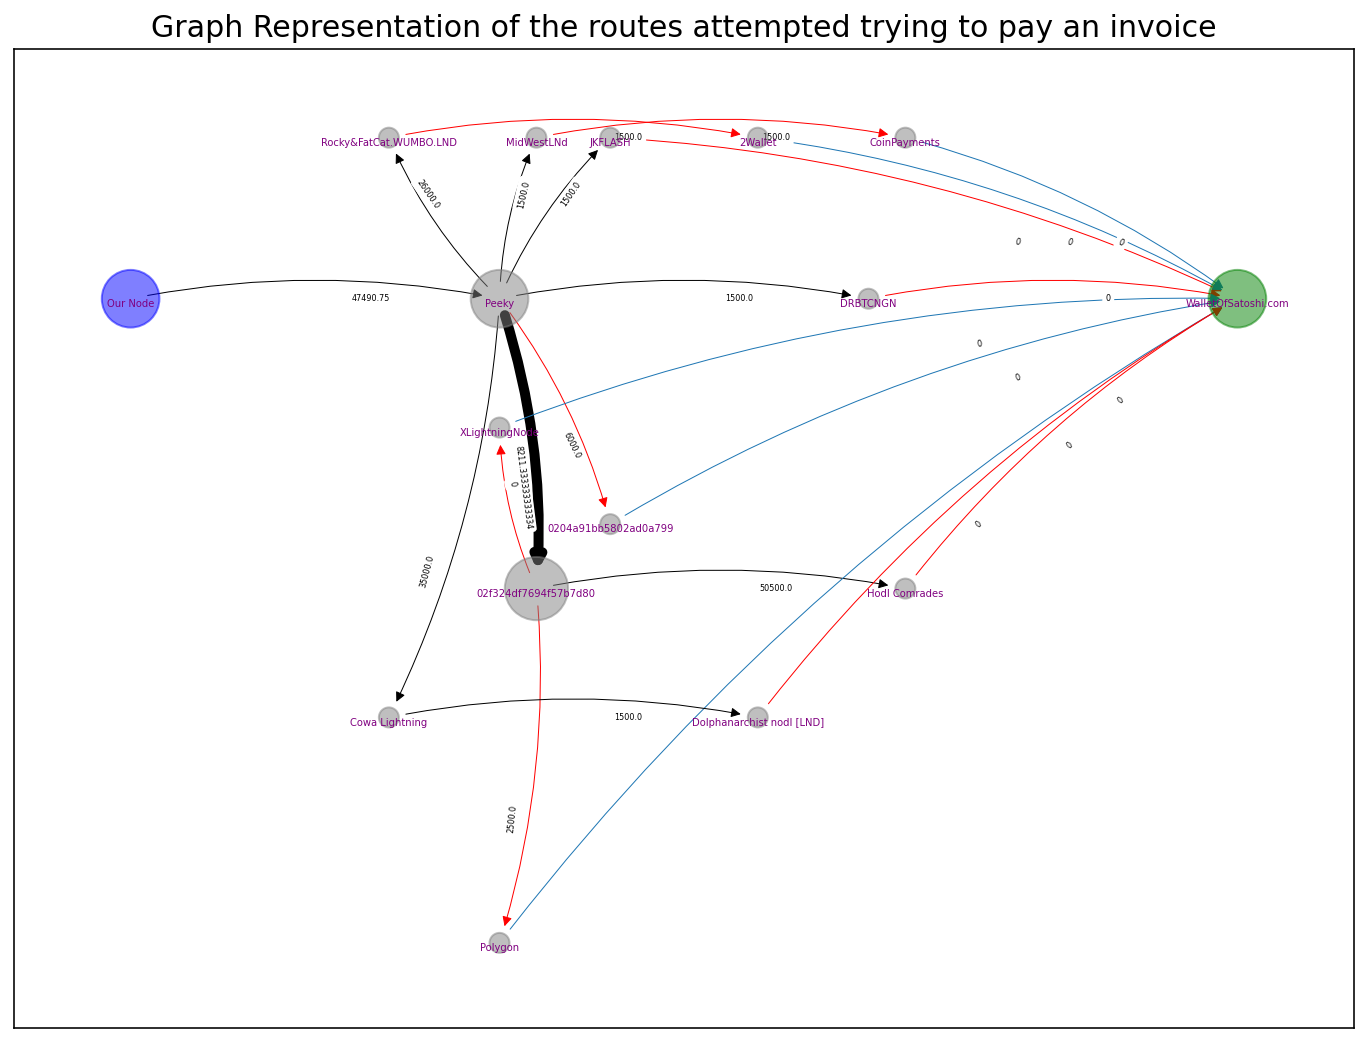

In [80]:
show_graph_of_routes(g, node_positions, nodes_colors, widths,
                     edges_colors, nodes_size=node_size, draw_fee_labels=True,
                     fee_labels=edge_fee_labels)

## Colour successful path in green

In [81]:
def colour_successful_path(g, edges_df, pay_df):
    
    edges = edges_df.copy()
    payment = pay_df.droplevel('attempt').reset_index(drop=True)
    
    edges['status'] = payment['pay_status']
    
    for i, edge in edges.iterrows():
        if edge['status'] == 1:
            g[edge.source][edge.destination]['color'] = 'green'

In [82]:
colour_successful_path(g, edges_list, pay_6611)

In [83]:
edges_colors = np.array([c for *_, c in g.edges.data('color')])

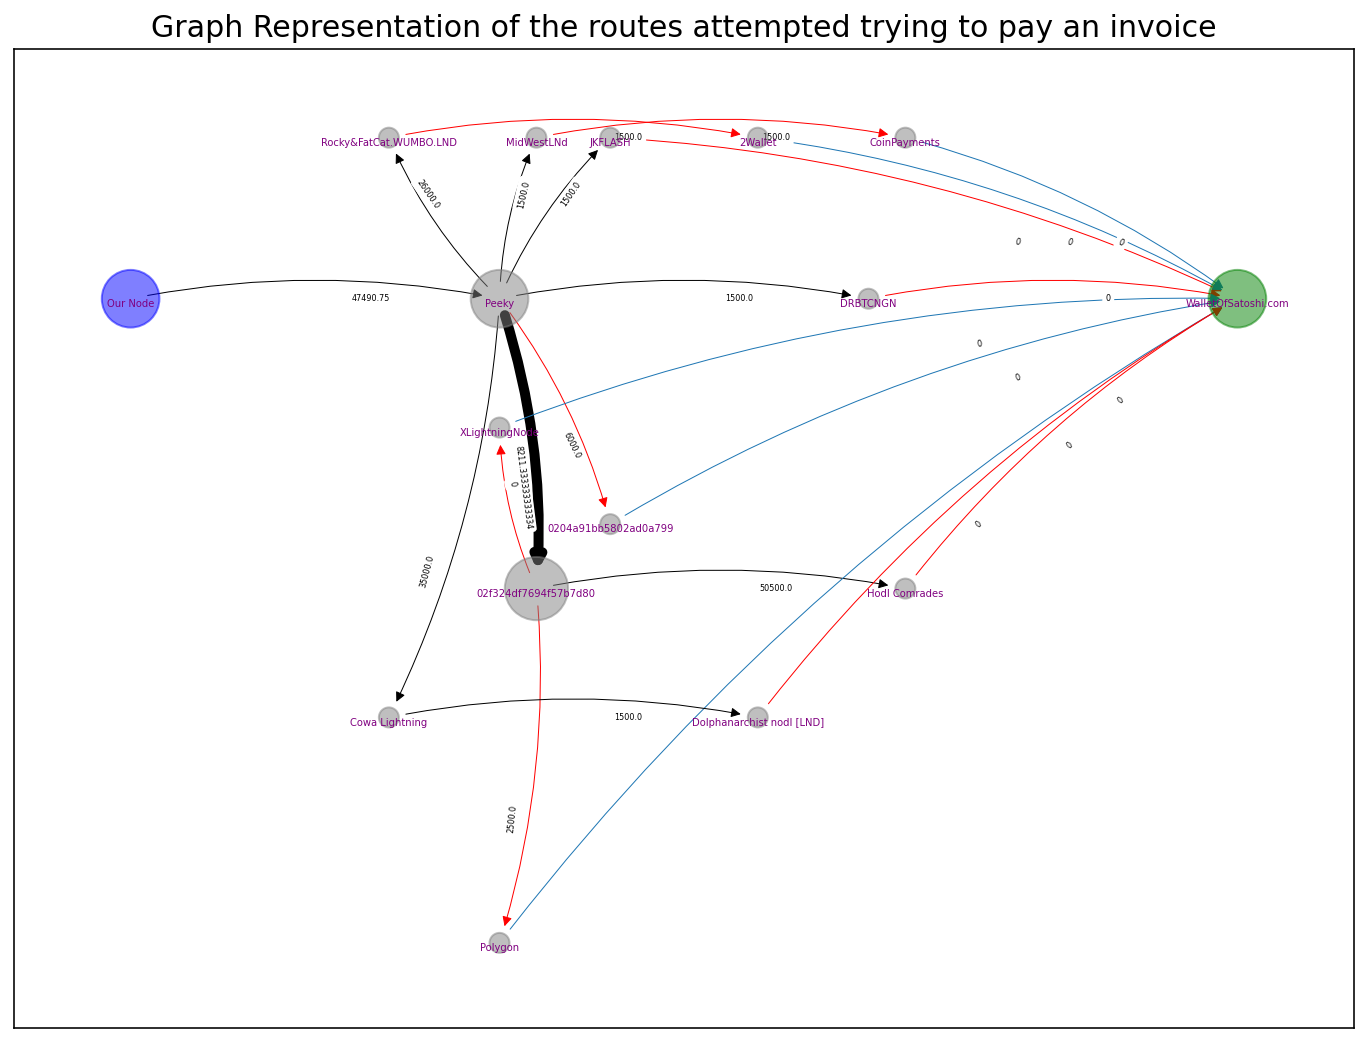

In [84]:
show_graph_of_routes(g, node_positions, nodes_colors, widths,
                     edges_colors, nodes_size=node_size, draw_fee_labels=True,
                     fee_labels=edge_fee_labels)

In [85]:
pay_6611

chan_id  \
attempt hop                       
0       0    816535817765847040   
        1    806908493983383552   
        2    790030990489288704   
1       0    816535817765847040   
        1    785309687609032705   
        2    771712027239120896   
2       0    816535817765847040   
        1    791534022859161601   
        2    784337719338991617   
3       0    816535817765847040   
        1    792372950341189633   
        2    803627551291342849   
        3    790788553945645056   
4       0    816535817765847040   
        1    791665964325011456   
        2    764291423219875840   
        3    805537402915651585   
5       0    816535817765847040   
        1    791665964325011456   
        2    803836458398121984   
        3    786638997103312896   
6       0    816535817765847040   
        1    791665964325011456   
        2    812624854903947265   
        3    810838148537647104   
7       0    816535817765847040   
        1    784398192435134464   
        2    813936572325167104   
        3    801382348593496065   
8       0    816535817765847040   
        1    786402602045472768   
        2    811799121703272449   
        3    795956258659434497   

                                                       pub_key  fee_msat  \
attempt hop                                                                
0       0    0250baf7a558091eb9c93f43d595b795db61bd2b55ca01...   62490.0   
        1    02c47d6d1cc3413cb89b8033b5df7033605ed339a8d857...    1500.0   
        2    035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8...       NaN   
1       0    0250baf7a558091eb9c93f43d595b795db61bd2b55ca01...   97490.0   
        1    02e2d1b40f08d2ca704c7f62397eec42245cb394d4a07d...    1500.0   
        2    035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8...       NaN   
2       0    0250baf7a558091eb9c93f43d595b795db61bd2b55ca01...   62490.0   
        1    0204a91bb5802ad0a799acfd86ef566da03d80cc9e13ac...    6000.0   
        2    035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8...       NaN   
3       0    0250baf7a558091eb9c93f43d595b795db61bd2b55ca01...   17490.0   
        1    02b56712f65c281a1eacee0bb034699a716535a1c8ae1c...    1500.0   
        2    03afa7a8196dbca763ee6f9a34b634a7adc03f154e5d69...    1500.0   
        3    035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8...       NaN   
4       0    0250baf7a558091eb9c93f43d595b795db61bd2b55ca01...   32493.0   
        1    02f324df7694f57b7d800d5a64f62fb226eabc8fbacb99...    7621.0   
        2    0244da84f0248cbb6d4cc0cec3e9a91ce97c925cc41279...   50500.0   
        3    035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8...       NaN   
5       0    0250baf7a558091eb9c93f43d595b795db61bd2b55ca01...   32490.0   
        1    02f324df7694f57b7d800d5a64f62fb226eabc8fbacb99...    8034.0   
        2    02587c51c3196667c9112c688ccd2356d1a3983610cf19...       NaN   
        3    035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8...       NaN   
6       0    0250baf7a558091eb9c93f43d595b795db61bd2b55ca01...   32490.0   
        1    02f324df7694f57b7d800d5a64f62fb226eabc8fbacb99...    8979.0   
        2    02c55b405e1d5afc8d59c38ad1eb089f86dc4a296767cf...    2500.0   
        3    035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8...       NaN   
7       0    0250baf7a558091eb9c93f43d595b795db61bd2b55ca01...       NaN   
        1    03e29d2c639b0789e9559a234843ec9e5b6b9009a249ad...   26000.0   
        2    0363ca052a083fc5196267fe51ceca183babd765a7e140...    1500.0   
        3    035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8...       NaN   
8       0    0250baf7a558091eb9c93f43d595b795db61bd2b55ca01...   42493.0   
        1    0294fd62bc6f4ad2804dfb01237baaf8b8dd5646cf6063...   35000.0   
        2    02676e95f1ecd32ea66b42efc7c0eac9542de2b05c0450...    1500.0   
        3    035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8...       NaN   

             hop_fail  pay_status                 node_alias  
attempt hop                                                   
0       0  

# Interactive visualization

The last visualization has:
- All routes tried in a payment attempt. 
- Our node coloured different from the rest to differentiate it easily.
- Destination node coloured different from the rest to differentiate it easily.
- Nodes size is determined based on the times a node has been part of a route.
- Nodes alias on top of each node.
- Channels thickness is determined based on the times a channel has been part of a route.
- Channels colors is determined based on whether a channel has failed, or if it has been part of the successful route.
- Average fee in msat next to each channel.

If we want to look at more payment attempts in the same visualization, then we would have to aggregate data and adjust the parameters of the properties above. As more payments were to be added to the visualization, it would be more difficult to read and interpret the data. Hence, making an interactive visualization would help the user look at the important information.

[Altair](https://altair-viz.github.io/index.html) is a visualization library for making interactive visualizations. An advantaje to other visualization libraries is that you can produce visualizations with a minimal amount of code.

Some main ideas to make an interactive visualization for the payment attempts:
- Scrolldown menu to select the payment attempts to visualize.
- Zoom in and out.
- Panning.
- Drag the pointer on top of a node to see the node alias, number of times it's been part of a route, and number of failures.
- Drag the pointer on top of a channel to see the average fee of the channel, number of times it's been part of a route, number of failures, and the number of times it's been part of a successful route.
- Binding checkboxes:
    - Show/hide channels with only one attempt.
    - Show only successful routes.
